fatal: destination path 'stocknet-dataset' already exists and is not an empty directory.
Date,Open,High,Low,Close,Adj Close,Volume
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
2012-09-11,95.015717,95.728569,93.785713,94.370003,85.265068,125995800
2012-09-12,95.264282,95.699997,93.714287,95.684288,86.452538,178058300
2012-09-13,96.767143,97.928574,96.395714,97.568573,88.155037,149590000
2012-09-14,98.565712,99.568573,98.269997,98.754288,89.226341,150118500
2012-09-17,99.907143,99.971428,99.230003,99.968575,90.323479,99507800
2012-09-18,99.982857,100.332855,99.488571,100.272858,90.598404,93375800
2012-09-19,100.037140,100.570000,99.938568,100.300003,90.622932,81718700
2012-09-20,99.87999

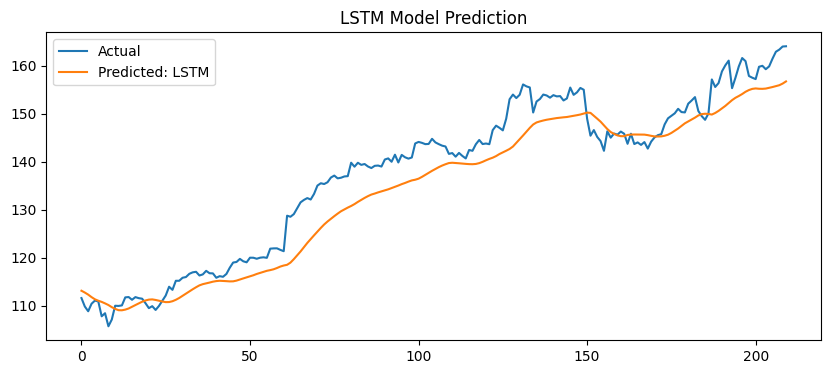

LSTM -> MAE: 4.3093, RMSE: 5.0862, R²: 0.9032

Training BiLSTM...


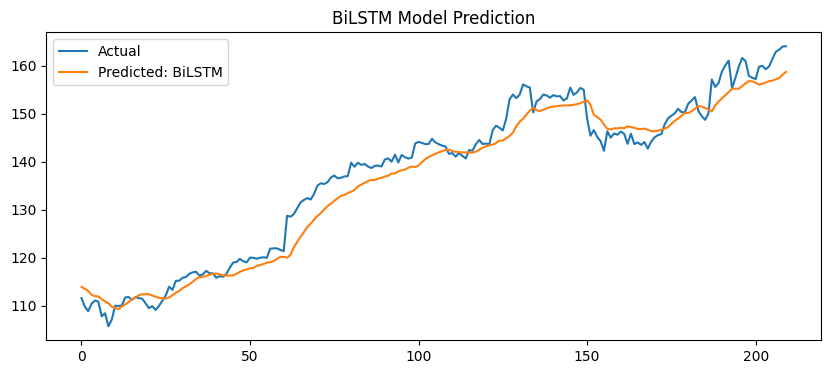

BiLSTM -> MAE: 2.7840, RMSE: 3.3872, R²: 0.9571

Training RNN...


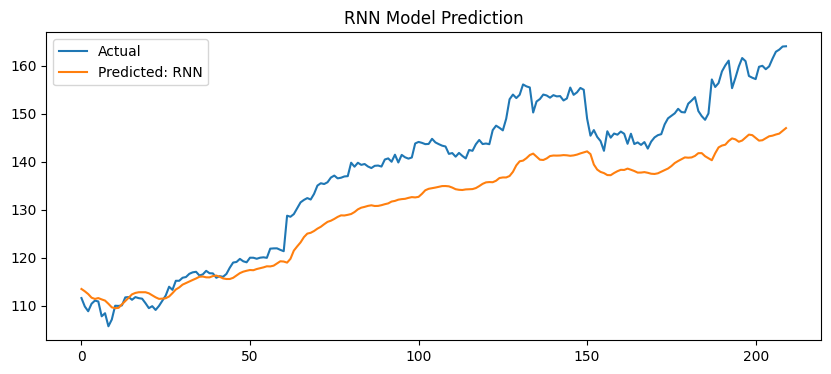

RNN -> MAE: 7.7575, RMSE: 9.0764, R²: 0.6918

Training CNN...


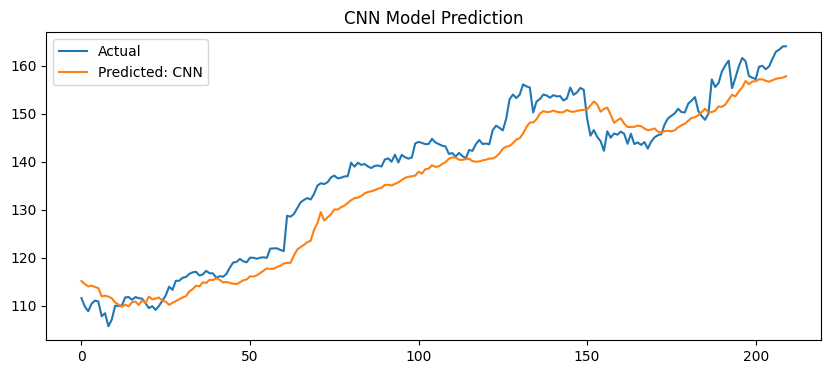

CNN -> MAE: 4.1110, RMSE: 4.7478, R²: 0.9157

Training BiLSTM+Attention...


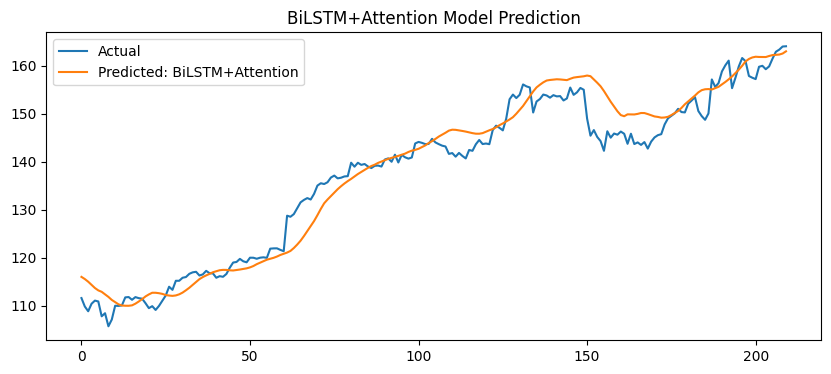

BiLSTM+Attention -> MAE: 2.8939, RMSE: 3.7893, R²: 0.9463


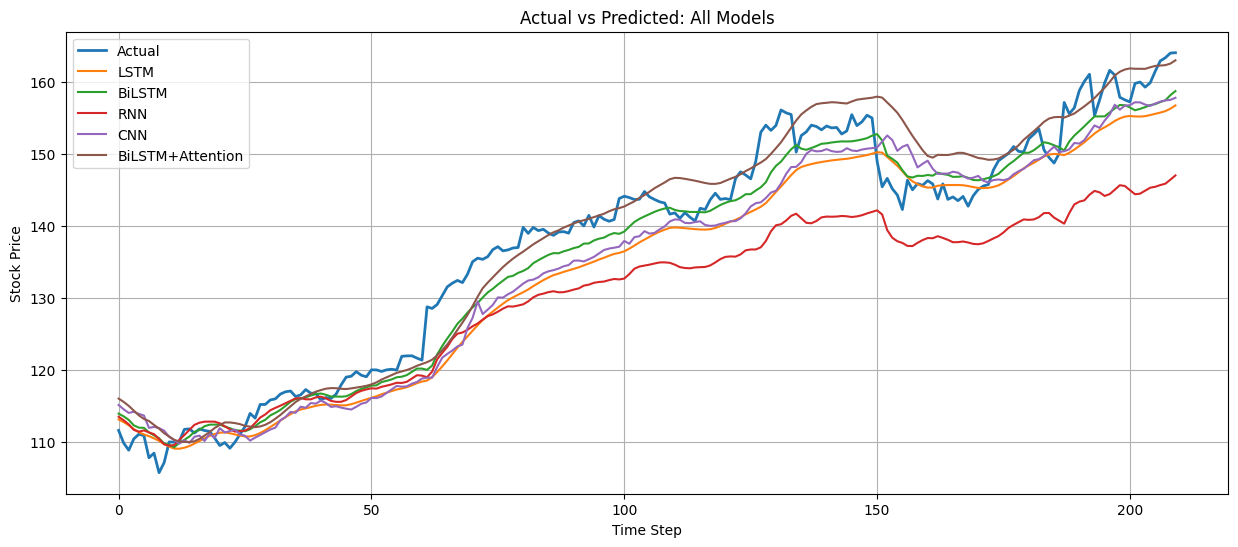


📊 Model Performance Summary:
           Model      MAE     RMSE  R² Score
          BiLSTM 2.783961 3.387177  0.957081
BiLSTM+Attention 2.893923 3.789262  0.946287
             CNN 4.110965 4.747786  0.915675
            LSTM 4.309284 5.086186  0.903226
             RNN 7.757547 9.076410  0.691822

🏆 Best Performing Model: BiLSTM with R² = 0.9571


In [7]:
# SETUP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#https://paperswithcode.com/dataset/stocknet-1
#https://github.com/yumoxu/stocknet-dataset
!git clone https://github.com/yumoxu/stocknet-dataset.git
!cat stocknet-dataset/price/raw/AAPL.csv

# Read and preprocess
df = pd.read_csv('stocknet-dataset/price/raw/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.drop(columns=['Adj Close'], inplace=True, errors='ignore')
df.dropna(inplace=True)
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Volume', 'MA_50', 'MA_200']
target = 'Close'

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
scaler_target = MinMaxScaler()
df[[target]] = scaler_target.fit_transform(df[[target]])

def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features].values, df[target].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# MODEL CLASSES
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)
        return torch.sum(weights * lstm_output, dim=1)

class BaseModel(nn.Module):
    def __init__(self, type='lstm', attention=False):
        super(BaseModel, self).__init__()
        self.type = type
        self.attention = attention
        hidden = 64
        layers = 2
        self.input_size = 6
        self.seq_length = 10

        if type == 'cnn':
            self.conv = nn.Conv1d(in_channels=self.input_size, out_channels=32, kernel_size=2)
            conv_output_size = self.seq_length - 2 + 1
            self.flatten_size = 32 * conv_output_size
            self.fc_cnn = nn.Linear(self.flatten_size, 1)
        else:
            if type == 'lstm':
                self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=hidden, num_layers=layers, batch_first=True)
            elif type == 'bilstm':
                self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=hidden, num_layers=layers, batch_first=True, bidirectional=True)
            elif type == 'rnn':
                self.rnn = nn.RNN(input_size=self.input_size, hidden_size=hidden, num_layers=layers, batch_first=True)
            self.attn = Attention(hidden * 2 if type == 'bilstm' else hidden)
            self.fc = nn.Linear(hidden * 2 if type == 'bilstm' else hidden, 1)

    def forward(self, x):
        if self.type == 'cnn':
            x = x.permute(0, 2, 1)
            x = torch.relu(self.conv(x))
            x = x.view(x.size(0), -1)
            return self.fc_cnn(x)
        else:
            rnn_out, _ = self.rnn(x)
            if self.attention:
                context = self.attn(rnn_out)
                return self.fc(context)
            else:
                return self.fc(rnn_out[:, -1, :])

# Training & Evaluation
def train_and_eval(model, name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test_tensor).numpy()
        actual = y_test_tensor.numpy()

    pred_inv = scaler_target.inverse_transform(pred)
    actual_inv = scaler_target.inverse_transform(actual)

    mae = mean_absolute_error(actual_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
    r2 = r2_score(actual_inv, pred_inv)

    plt.figure(figsize=(10,4))
    plt.plot(actual_inv, label="Actual")
    plt.plot(pred_inv, label=f"Predicted: {name}")
    plt.legend()
    plt.title(f"{name} Model Prediction")
    plt.show()

    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return r2, mae, rmse, pred_inv

# Run models
models = [
    ('LSTM', BaseModel(type='lstm')),
    ('BiLSTM', BaseModel(type='bilstm')),
    ('RNN', BaseModel(type='rnn')),
    ('CNN', BaseModel(type='cnn')),
    ('BiLSTM+Attention', BaseModel(type='bilstm', attention=True))
]

results = {}
final_preds = {}
metrics_table = []

for name, model in models:
    print(f"\nTraining {name}...")
    r2, mae, rmse, pred_inv = train_and_eval(model, name)
    results[name] = r2
    final_preds[name] = pred_inv
    metrics_table.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R² Score': r2})

# Plot combined
actual_inv = scaler_target.inverse_transform(y_test_tensor.numpy())
plt.figure(figsize=(15, 6))
plt.plot(actual_inv, label="Actual", linewidth=2)
for name, pred in final_preds.items():
    plt.plot(pred, label=name)
plt.title("Actual vs Predicted: All Models")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Summary Table and Best Model Display
metrics_df = pd.DataFrame(metrics_table)
metrics_df = metrics_df.sort_values(by="R² Score", ascending=False)

print("\n📊 Model Performance Summary:")
print(metrics_df.to_string(index=False))

# Display best model
best_row = metrics_df.iloc[0]
print(f"\n🏆 Best Performing Model: {best_row['Model']} with R² = {best_row['R² Score']:.4f}")
